In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import os

# Set seed
torch.manual_seed(42)

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
# 1. Load and Preprocess MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [21]:
# 2. Define Models
class FeedforwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(4*4*32, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))     # (batch, 16, 24, 24)
        x = F.max_pool2d(x, 2)        # (batch, 16, 12, 12)
        x = F.relu(self.conv2(x))     # (batch, 32, 8, 8)
        x = F.max_pool2d(x, 2)        # (batch, 32, 4, 4)
        x = x.view(-1, 4*4*32)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [22]:
# Choose model
model = CNN().to(device)
# model = FeedforwardNN().to(device)

In [23]:
# 3. Train the model
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies = [], []

for epoch in range(1, 6):  # 5 epochs
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = output.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    
    avg_loss = epoch_loss / len(train_loader)
    acc = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(acc)
    
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}, Accuracy = {acc:.4f}")

Epoch 1: Loss = 0.1531, Accuracy = 0.9539
Epoch 2: Loss = 0.0450, Accuracy = 0.9865
Epoch 3: Loss = 0.0305, Accuracy = 0.9907
Epoch 4: Loss = 0.0239, Accuracy = 0.9926
Epoch 5: Loss = 0.0177, Accuracy = 0.9943


In [24]:
# 4. Evaluate the model
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9919


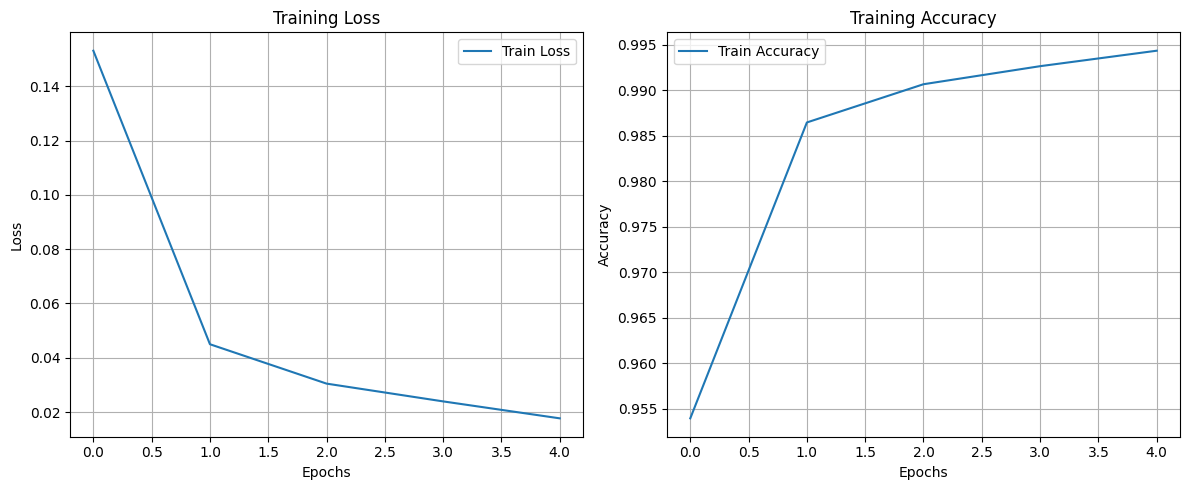

In [25]:
# 5. Plot loss and accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Training Loss')
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.title('Training Accuracy')
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

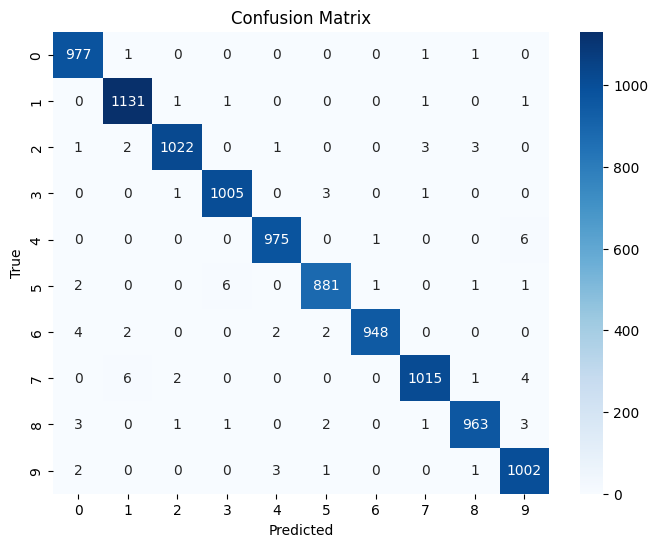

In [26]:
# 6. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()